# Evaluate water mass properties on the Amundsen Shelf using Pierre's observations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux
from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.grid import region_mask
from nemo_python_git.constants import region_edges, region_edges_flag, region_points, region_names

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test6/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Define regions for plots

In [4]:
# Dictionary of lon-lat points bounding given region. Will be used to "cut" the continental shelf mask (build_shelf_mask in utils.py) either north-south or east-west depending on the value of region_edges_flag. The first point and its connected N/S (or E/W) neighbours will be included in the mask, but not the second. The direction of travel is west to east around the coastline.

region_edges = {
    'abbot'             : [[-103.2, -71.8] , [-83, -72]],
    'amery'             : [[66.5, -67.5]   , [79.5, -68]],
    'amundsen_sea'      : [[-157.5, -76.5] , [-102.75, -72.5]],
    'bellingshausen_sea': [[-102.75, -72.5], [-57.25, -62]],
    'cosgrove'          : [[-104.24, -73.846], [-102.91, -73.2]],
    'dotson_crosson'    : [[-114.7, -73.8] , [-107.5, -75.3]],
    'dotson_front'      : [[-112.5, -74.4] , [-110.5, -73.85]], # just shelf
    'pine_island'       : [[-102.6, -75.1] , [-101.5, -74.2]],
    'pine_island_bay'   : [[-104.0, -74.8] , [-103, -74.2]], # just shelf
    'east_antarctica'   : [[-26, -75.5]    , [169.5 , -71]], # includes Amery
    'filchner_ronne'    : [[-57, -71.5]    , [-26.0 , -75.5]],
    'getz'              : [[-135, -74.5]   , [-114.7, -73.8]],
    'larsen'            : [[-57.25, -62]   , [-57, -71.5]],
    'ross'              : [[169.5, -71]    , [-157.5, -76.5]],
    'thwaites'          : [[-107.5, -75.3] , [-103.6, -74.5]],
    'west_antarctica'   : [[-157.5, -76.5] , [-57.25, -62]], # Amundsen and Bellingshausen
}
region_edges_flag = {
    'abbot'             : ['NS', 'NS'],
    'amery'             : ['NS', 'NS'],
    'amundsen_sea'      : ['NS', 'NS'],
    'bellingshausen_sea': ['NS', 'NS'],
    'cosgrove'          : ['EW', 'EW'],
    'dotson_crosson'    : ['NS', 'NS'],
    'dotson_front'      : ['EW', 'EW'],
    'east_antarctica'   : ['NS', 'NS'],
    'filchner_ronne'    : ['EW', 'NS'],
    'getz'              : ['NS', 'NS'],
    'larsen'            : ['NS', 'EW'],
    'pine_island'       : ['NS', 'EW'], 
    'pine_island_bay'   : ['NS', 'EW'],
    'ross'              : ['NS', 'NS'],
    'thwaites'          : ['NS', 'EW'],
    'west_antarctica'   : ['NS', 'NS'],
}
# Dictionary of lon-lat points which are definitely in the given region. The region is then defined by connectivity to that point (eg selecting specific ice shelf cavities in single_cavity_mask in utils.py).
region_points = {
    'abbot': [-95, -73],
    'brunt': [-20, -75],
    'pine_island': [-101, -75],
}
# Names of each region
region_names = {
    'all'               : 'Antarctic',
    'abbot'             : 'Abbot Ice Shelf',
    'amery'             : 'Amery',
    'amundsen_sea'      : 'Amundsen Sea',
    'amundsen_west_shelf_break': 'Western Amundsen Sea shelf break',
    'bellingshausen_sea': 'Bellingshausen Sea',
    'brunt'             : 'Brunt and Riiser-Larsen Ice Shelves',
    'cosgrove'          : 'Cosgrove Ice Shelf',
    'dotson_crosson'    : 'Dotson-Crosson Ice Shelf',
    'dotson_front'      : 'front of Dotson',
    'east_antarctica'   : 'East Antarctica',
    'filchner_ronne'    : 'Filchner-Ronne',
    'getz'              : 'Getz Ice Shelf',
    'larsen'            : 'Larsen',
    'pine_island'       : 'Pine Island Ice Shelf',
    'pine_island_bay'   : 'Pine Island Bay',
    'ross'              : 'Ross',
    'thwaites'          : 'Thwaites Ice Shelf',
    'west_antarctica'   : 'West Antarctica',
}

In [5]:
from nemo_python_git.utils import remove_disconnected, closest_point
from nemo_python_git.grid import build_shelf_mask, single_cavity_mask, build_ice_mask, region_mask

Test dotson_bay, getz, dotson, crosson, pine_island_bay

In [6]:
nemo_file = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc').squeeze()

In [7]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

bathy  = xr.where((mesh_sub.bathy_metry==0), np.nan, mesh_sub.bathy_metry)
cavity = xr.where((mesh_sub.isfdraft==0), np.nan, mesh_sub.isfdraft)

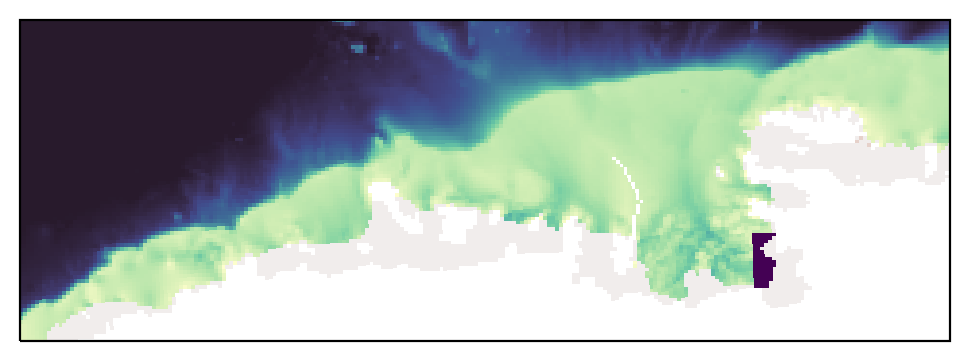

In [10]:
# now do the same for a transect in the simulation

nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,1, figsize=(6,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=200)

img1 = ax.pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                     bathy.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)
img1 = ax.pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                     cavity.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.amp_r,vmin=0,vmax=10)

# ['dotson_front','pine_island_bay','dotson_crosson', 'pine_island', 'thwaites', 'amundsen_sea', 'getz']
for region in ['pine_island']:
    region_type='shelf'
    mask, _, region_name = region_mask(region, nemo_file, option=region_type, return_name=True)
    mask_ds = xr.where(mask==0, np.nan, mask)
    img1 = ax.pcolormesh(nemo_mesh_ds.nav_lon, nemo_mesh_ds.nav_lat, mask_ds, transform=ccrs.PlateCarree(),rasterized=True)

ax.set_extent([-90, -150, -76, -70], ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels=True);
# gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;